### Importy

In [6]:
import pandas as pd
from scripts.essentials import *
from scripts.plots import *
from scripts.train_utilities import *
from sklearn.metrics import mean_squared_error
import joblib
import shap
import optuna
import lightgbm as lgb

In [7]:
prefix = "NFLX"

In [8]:
train_set = pd.read_csv("csv/"+prefix+'/train_set.csv')
test_set = pd.read_csv("csv/"+prefix+'/test_set.csv')
val_set = pd.read_csv("csv/"+prefix+'/val_set.csv')

In [9]:
train_set.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'future', 'influential', 'trustworthy',
       'not clickbait', 'finbert_Score', 'bart_Score', 'vader_Score',
       'future_finbert', 'future_bart', 'future_vader', 'influential_finbert',
       'influential_bart', 'influential_vader', 'trustworthy_finbert',
       'trustworthy_bart', 'trustworthy_vader', 'clickbait_finbert',
       'clickbait_bart', 'clickbait_vader', 'Date', '^GSPC_Close',
       '^GSPC_Volume', 'EURUSD=X_Close', 'NFLX_Open', 'NFLX_High', 'NFLX_Low',
       'NFLX_Close', 'NFLX_Volume', 'mean_future', 'mean_influential',
       'mean_trustworthy', 'mean_clickbait', 'sma_50', 'ema_20', 'rsi_14',
       'slowk', 'vwap', 'roc_14', 'Daily_Variation', 'High_Close_Pressure',
       'Low_Open_Pressure', 'Year', 'target_1', 'target_5', 'target_10',
       'target_20', 'target_1_std', 'target_5_std', 'target_10_std',
       'target_20_std'],
      dtype='object')

In [10]:
cols = ['future', 'influential', 'trustworthy',
       'not clickbait', 'finbert_Score', 'bart_Score', 'vader_Score',
       'future_finbert', 'future_bart', 'future_vader', 'influential_finbert',
       'influential_bart', 'influential_vader', 'trustworthy_finbert',
       'trustworthy_bart', 'trustworthy_vader', 'clickbait_finbert',
       'clickbait_bart', 'clickbait_vader', '^GSPC_Close',
       '^GSPC_Volume', 'EURUSD=X_Close', 'NFLX_Open', 'NFLX_High', 'NFLX_Low',
       'NFLX_Close', 'NFLX_Volume', 'mean_future', 'mean_influential',
       'mean_trustworthy', 'mean_clickbait', 'sma_50', 'ema_20', 'rsi_14',
       'slowk', 'vwap', 'roc_14', 'Daily_Variation', 'High_Close_Pressure',
       'Low_Open_Pressure']

In [11]:
X_train = train_set[cols]
y_train = train_set['target_1_std']
X_val = val_set[cols]
y_val = val_set['target_1_std']
X_test = test_set[cols][:-1]
y_test = test_set['target_1_std'][:-1]

In [12]:
feature_cols_space = cols

In [ ]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-9, 10, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-9, 10, log=True),
    }

    if feature_cols_space:
        selected_features = trial.suggest_categorical('selected_features', [feature_cols_space, None])
        if selected_features:
            X_train_subset = X_train[selected_features]
            X_test_subset = X_val[selected_features]
        else:
            X_train_subset = X_train
            X_test_subset = X_val
    else:
        X_train_subset = X_train
        X_test_subset = X_val

    model = lgb.LGBMRegressor(**params)

    model.fit(X_train_subset, y_train)

    y_pred = model.predict(X_test_subset)

    mse = mean_squared_error(y_val, y_pred)

    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30000)

best_params = study.best_params
print("Best Hyperparameters:", best_params)

In [85]:
best_trials = study.best_trials

for trial in best_trials:
    
    print(f"Trial {trial.number}: MSE = {trial.value}")

Trial 7752: MSE = 0.22142818320564184


In [39]:
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'num_leaves': 6, 'learning_rate': 0.09513966235589807, 'feature_fraction': 0.3877176574812101, 'bagging_fraction': 0.7724361328387499, 'bagging_freq': 10, 'lambda_l1': 0.3352059890233914, 'lambda_l2': 1.587282511709307, 'selected_features': ['future', 'influential', 'trustworthy', 'not clickbait', 'finbert_Score', 'bart_Score', 'vader_Score', 'future_finbert', 'future_bart', 'future_vader', 'influential_finbert', 'influential_bart', 'influential_vader', 'trustworthy_finbert', 'trustworthy_bart', 'trustworthy_vader', 'clickbait_finbert', 'clickbait_bart', 'clickbait_vader', '^GSPC_Close', '^GSPC_Volume', 'EURUSD=X_Close', 'NFLX_Open', 'NFLX_High', 'NFLX_Low', 'NFLX_Close', 'NFLX_Volume', 'mean_future', 'mean_influential', 'mean_trustworthy', 'mean_clickbait', 'sma_50', 'ema_20', 'rsi_14', 'slowk', 'vwap', 'roc_14', 'Daily_Variation', 'High_Close_Pressure', 'Low_Open_Pressure']}


Best Hyperparameters: {'num_leaves': 6, 'learning_rate': 0.09513966235589807, 'feature_fraction': 0.3877176574812101, 'bagging_fraction': 0.7724361328387499, 'bagging_freq': 10, 'lambda_l1': 0.3352059890233914, 'lambda_l2': 1.587282511709307, 'selected_features': ['future', 'influential', 'trustworthy', 'not clickbait', 'finbert_Score', 'bart_Score', 'vader_Score', 'future_finbert', 'future_bart', 'future_vader', 'influential_finbert', 'influential_bart', 'influential_vader', 'trustworthy_finbert', 'trustworthy_bart', 'trustworthy_vader', 'clickbait_finbert', 'clickbait_bart', 'clickbait_vader', '^GSPC_Close', '^GSPC_Volume', 'EURUSD=X_Close', 'NFLX_Open', 'NFLX_High', 'NFLX_Low', 'NFLX_Close', 'NFLX_Volume', 'mean_future', 'mean_influential', 'mean_trustworthy', 'mean_clickbait', 'sma_50', 'ema_20', 'rsi_14', 'slowk', 'vwap', 'roc_14', 'Daily_Variation', 'High_Close_Pressure', 'Low_Open_Pressure']}


In [13]:
best_cols = ['future', 'influential', 'trustworthy', 'not clickbait', 'finbert_Score',
              'bart_Score', 'vader_Score', 'future_finbert', 'future_bart', 'future_vader',
                'influential_finbert', 'influential_bart', 'influential_vader', 'trustworthy_finbert',
                  'trustworthy_bart', 'trustworthy_vader', 'clickbait_finbert', 'clickbait_bart', 'clickbait_vader',
                    '^GSPC_Close', '^GSPC_Volume', 'EURUSD=X_Close', 'NFLX_Open', 'NFLX_High', 'NFLX_Low', 'NFLX_Close',
                      'NFLX_Volume', 'mean_future', 'mean_influential', 'mean_trustworthy', 'mean_clickbait', 'sma_50',
                        'ema_20', 'rsi_14', 'slowk', 'vwap', 'roc_14', 'Daily_Variation', 'High_Close_Pressure', 'Low_Open_Pressure']

In [38]:
best_trial = study.best_trial
# Get the best MSE
best_mse = best_trial.value
print("Best Mean Squared Error:", best_mse)

Best Mean Squared Error: 0.22142818320564184


In [ ]:
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_train[best_cols], y_train)

In [ ]:
test_pred = final_model.predict(X_test[best_cols])
val_pred = final_model.predict(X_val[best_cols])
train_pred = final_model.predict(X_train[best_cols])

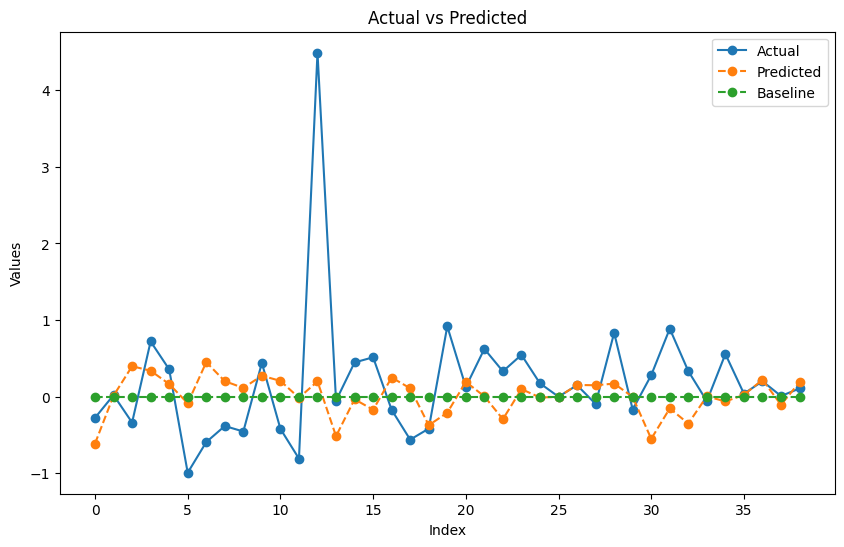

In [51]:
plot_actual_vs_predicted(y_test, test_pred, [0 for i in range(len(y_test))])

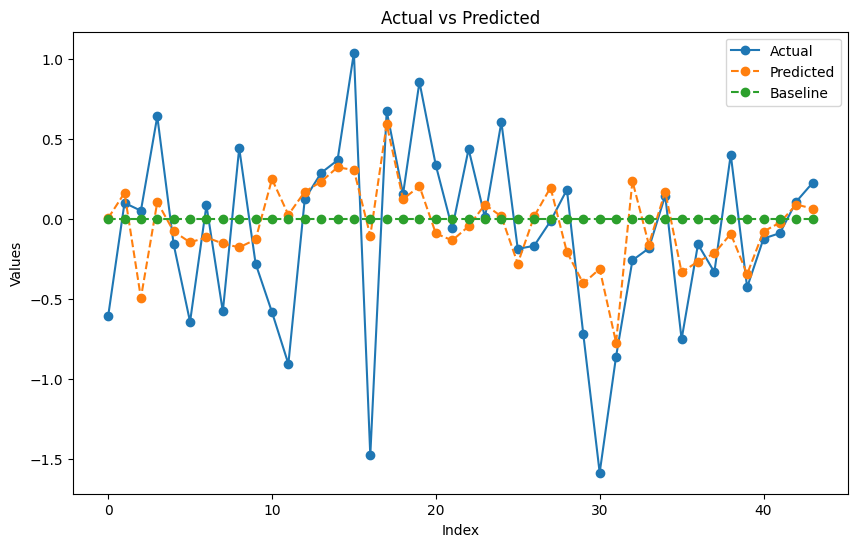

In [50]:
plot_actual_vs_predicted(y_val, val_pred, [0 for i in range(len(y_val))])

In [52]:
count_signs_matrix(y_val, val_pred)

array([[14,  7],
       [ 6, 17]])

In [81]:
test_pred_thr = []
y_test_thr = []

thr = 0.5
for i,y_t in zip(test_pred,y_test):
    if i>thr:
        test_pred_thr.append(1)
        y_test_thr.append(y_t)
    elif i<-thr:
        test_pred_thr.append(-1)
        y_test_thr.append(y_t)

count_signs_matrix(y_test_thr, test_pred_thr)

array([[0, 1],
       [0, 2]])

In [53]:
count_signs_matrix(y_test, test_pred)

array([[13, 11],
       [ 9,  6]])

In [61]:
count_signs_matrix(y_test[1:], y_test.shift(1)[1:])

array([[15,  9],
       [ 8,  6]])

In [55]:
calculate_metrics( y_train, train_pred,
                   y_test, test_pred,
                    y_val , val_pred)

,MAE,MSE,RMSE,R2 Score,MAPE,MASE
Train,0.455060,0.481568,0.693951,0.518432,223.659658,0.510739
Test,0.538804,0.765659,0.875019,-0.102054,177.498881,0.604730
Validation,0.335806,0.221428,0.470562,0.260547,150.110638,0.376894


In [58]:
# baseline dajemy 0 zawsze
calculate_metrics( y_train, [0 for i in range(len(train_pred))],
                   y_test, [0 for i in range(len(test_pred))],
                   y_val , [0 for i in range(len(val_pred))])

,MAE,MSE,RMSE,R2 Score,MAPE,MASE
Train,0.605326,1.000000,1.000000,0.000000,100.0,0.679391
Test,0.484519,0.730189,0.854511,-0.051001,100.0,0.543802
Validation,0.418895,0.307218,0.554272,-0.025945,100.0,0.470149


In [60]:
# baseline bierzemy poprzednią opcję do przodu
calculate_metrics( y_train[1:], y_train.shift(1)[1:],
                   y_test[1:], y_test.shift(1)[1:],
                    y_val[1:] , y_val.shift(1)[1:])

,MAE,MSE,RMSE,R2 Score,MAPE,MASE
Train,0.890983,1.970558,1.403766,-0.970573,690.777585,1.000002
Test,0.722680,1.616271,1.271326,-1.285326,1733.935541,0.811106
Validation,0.586303,0.576015,0.758956,-0.920303,334.136936,0.658042


In [ ]:
model_filename = 'lgb_1d_1w.joblib'
joblib.dump(final_model, model_filename)

In [4]:
model_path = 'models/NFTX/lgb_1d_1w.joblib'
loaded_model = joblib.load(model_path)

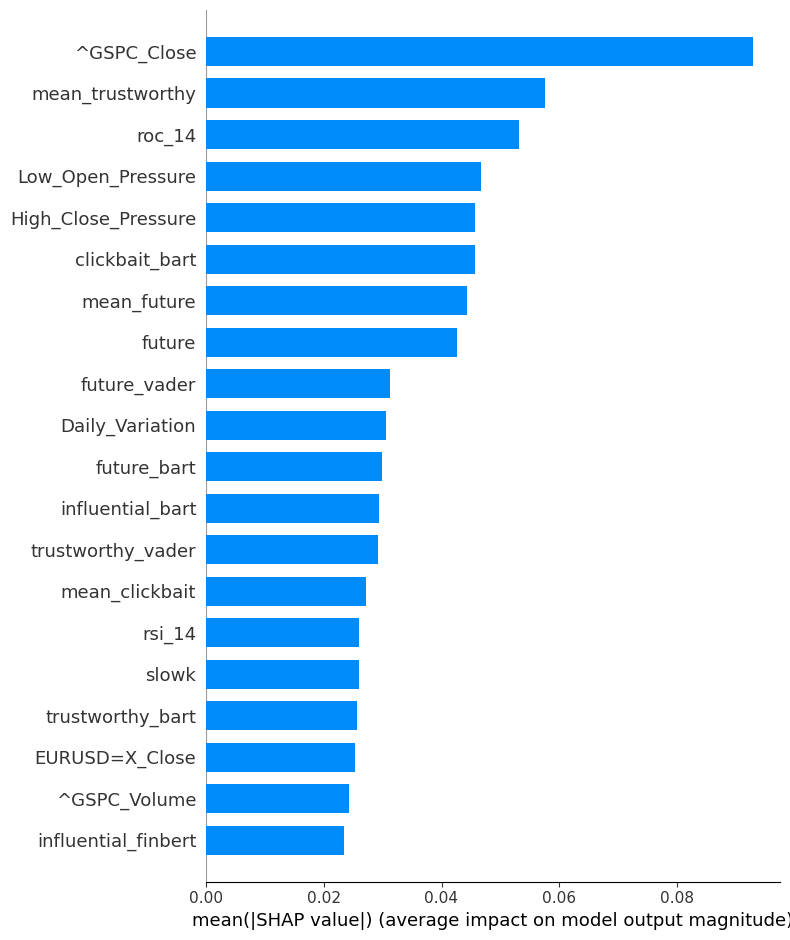

In [15]:
explainer = shap.TreeExplainer(loaded_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_val[best_cols])

# Summary plot
shap.summary_plot(shap_values, X_val[best_cols], feature_names=X_val[best_cols].columns, plot_type="bar", show=False)
plt.show()